# Footfall Counter

## Import required Libraries

In [113]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
from IPython.display import Video, display
from ultralytics import YOLO

%matplotlib inline

## Define Video Path and Region of Interest (ROI)

In [2]:
video_path = "../data/853874-hd_1920_1080_25fps.mp4"
video_roi = (411, 654, 805, 669)

## Visualize ROI on a Video Frame

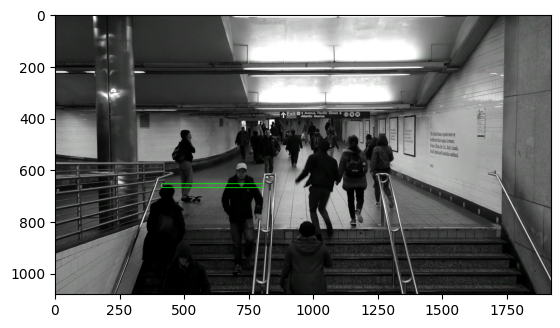

In [101]:
cap = cv2.VideoCapture(video_path)

# Get total frame count and select a middle frame
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
if total_frames == 0:
    raise ValueError("Video has no frames or frame count could not be determined")
visualization_frame = min(100, total_frames // 2)

# Grab a frame (e.g., 100th frame)
cap.set(cv2.CAP_PROP_POS_FRAMES, visualization_frame)
ret, frame = cap.read()
cap.release()

# Draw ROI on Visualization Frame
frame = cv2.rectangle(frame, video_roi[:2], video_roi[2:], (0, 255, 0), 2)

# Show Visualized ROI
plt.imshow(frame)

## Load YOLO11 Model

In [102]:
model = YOLO("yolo11n.pt")

## Perfom Object Detection and Tracking of Persons

In [118]:
track_generator = model.track(
    source=video_path,
    classes=[0],
    conf=0.5,
    tracker="../botsort.yaml",
    batch=1,
    stream=True,
)

In [119]:
frames_array = []
entry_count = 0
exit_count = 0
tracked_objects = {}
recent_events = {}  # Track recent entry/exit events
DEBOUNCE_FRAMES = 349  # Minimum frames between entry/exit for same object
frame_number = 0

for tracks in track_generator:
    frame_number += 1

    # Draw Bounding Boxes, Track Ids and ROI
    plotted_tracks = tracks.plot()
    plotted_tracks = cv2.rectangle(
        plotted_tracks, video_roi[:2], video_roi[2:], (0, 255, 0), 2
    )

    # Process each detected track
    if tracks.boxes is not None and tracks.boxes.id is not None:
        person_boxes = tracks.boxes.xyxy.cpu().numpy()  # Get bounding boxes for humans
        track_ids = tracks.boxes.id.cpu().numpy()  # Get track IDs

        for i, track_id in enumerate(track_ids):
            # Get center point of current detection
            x1, y1, x2, y2 = person_boxes[i]
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
            current_pos = (center_x, center_y)

            # Check if object crosses ROI boundary
            roi_x1, roi_y1, roi_x2, roi_y2 = video_roi

            # Check if current position is inside ROI
            inside_roi = roi_x1 <= center_x <= roi_x2 and roi_y1 <= center_y <= roi_y2

            # If we have previous position for this track
            track_id = int(track_id)
            if track_id in tracked_objects:
                prev_pos, prev_inside = tracked_objects[track_id]

                # Detect crossing: was outside, now inside = Entry
                if not prev_inside and inside_roi:
                    # Check if this object had a recent exit
                    if (
                        track_id in recent_events
                        and frame_number - recent_events[track_id]["frame"]
                        <= DEBOUNCE_FRAMES
                    ):
                        recent_events[track_id] = {
                            "type": "entry",
                            "frame": frame_number,
                        }
                        continue
                    recent_events[track_id] = {"type": "entry", "frame": frame_number}
                    entry_count += 1
                    plotted_tracks = cv2.putText(
                        plotted_tracks,
                        "ENTRY",
                        (center_x - 30, center_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        (0, 255, 0),
                        2,
                    )

                # Detect crossing: was inside, now outside = Exit
                elif prev_inside and not inside_roi:
                    if (
                        track_id in recent_events
                        and frame_number - recent_events[track_id]["frame"]
                        <= DEBOUNCE_FRAMES
                    ):
                        recent_events[track_id] = {
                            "type": "exit",
                            "frame": frame_number,
                        }
                        continue
                    recent_events[track_id] = {"type": "exit", "frame": frame_number}
                    exit_count += 1
                    plotted_tracks = cv2.putText(
                        plotted_tracks,
                        "EXIT",
                        (center_x - 30, center_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        (0, 0, 255),
                        2,
                    )

            # Update tracked object position
            tracked_objects[track_id] = (current_pos, inside_roi)

    # Display counts on frame
    plotted_tracks = cv2.putText(
        plotted_tracks,
        "Entries: " + str(entry_count),
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
    )
    plotted_tracks = cv2.putText(
        plotted_tracks,
        "Exits: " + str(exit_count),
        (10, 70),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2,
    )

    # Append frame to array
    frames_array.append(plotted_tracks)


video 1/1 (frame 1/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 12 persons, 58.8ms
video 1/1 (frame 2/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 12 persons, 55.3ms
video 1/1 (frame 3/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 11 persons, 48.3ms
video 1/1 (frame 4/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 11 persons, 46.0ms
video 1/1 (frame 5/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 12 persons, 44.3ms
video 1/1 (frame 6/349) /Users/shrijeet/persona/Footfall-Counter-using-Computer-Vision/notebooks/../data/853874-hd_1920_1080_25fps.mp4: 384x640 11 persons, 49.7ms
video 1/1 (frame 7/34

## Visualize Tracking Results

In [120]:
def get_video_fps(video_path):
    """Read FPS from input video."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    # Default fallback if FPS cannot be read
    return int(fps) if fps and fps > 0 else 25


# Save frames as MP4 video
def save_frames_as_video(frames_array, output_path="tracking_video.mp4", fps=25):
    fps = get_video_fps(video_path) if video_path else 25
    height, width = frames_array[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*"H264")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames_array:
        # Convert RGB to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        out.write(frame_bgr)

    out.release()
    return output_path


# Save and display
input_video_path = f"tracking_output_{datetime.now().strftime('%Y%m%d_%H%M%S')}.mp4"
tracked_video_path = save_frames_as_video(frames_array, input_video_path, fps=25)
display(Video(filename=tracked_video_path))

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
